# Building various models and testing them

In [1]:
# Importing the required libraries
import numpy as np
import os
import pickle
import pandas as pd
from ast import literal_eval

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib
import matplotlib.pyplot as plt
import scikitplot as skplt

# We can build some calibaration curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

# Chaning back to the resource directory if it is not there
if("Res" not in os.getcwd()):
    os.chdir("..")

/Users/gouravsanjuktabhabesh/.conda/envs/ml_101_env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
attributes_hot_encode = pd.read_csv("Res/processed_data/attributes_df.csv",sep=",")
col_attributes = []
with open("Res/processed_data/attributes_names.txt", 'r') as f:
    col_attributes.extend(f.read().split())

# Removing those mails that have no text inside them such as Res/enron1/spam/1733.2004-07-29.GP.spam.txt
attributes_hot_encode.drop(attributes_hot_encode.index\
                           [np.where(np.isnan(attributes_hot_encode[["median_useful_token_len"]]))[0]],inplace=True)

In [22]:
enron_measure_model = pd.DataFrame(columns=["Enron_dataset","spam","ham","train_spam","train_ham",
                                            "test_spam","test_ham","tp","tn","fp","fn","acc","recall","specificity"])

def exec_model(enron_dataset_no,intial_df,model_type="logistic"):
    # Working with the Enron dataset
    ernron_df = intial_df.loc[intial_df["dataset"]=="enron"+str(enron_dataset_no)]

    # Baseline Features for the logistic regression model
    baseline_X_features = ['line_count', 'token_count', 'punctuations_count', 'single_char_count', 
                         'number_token_count', 'year_count', 'stopword_count','median_useful_token_len', 
                         'avg_useful_token_len', 'rareword_count','attributes_len']
    baseline_X_features.extend(col_attributes)
    Y_feature = "mail_label"

    # Subsetting the data as X and y
    spam = ernron_df[ernron_df["mail_label"]=="spam"]
    ham = ernron_df[ernron_df["mail_label"]=="ham"]

    X_train_spam, X_test_spam, y_train_spam, y_test_spam = \
    train_test_split(spam[baseline_X_features], spam[Y_feature], test_size=0.2, random_state=0)

    X_train_ham, X_test_ham, y_train_ham, y_test_ham = \
    train_test_split(ham[baseline_X_features], ham[Y_feature], test_size=0.2, random_state=0)

    X_train = pd.concat([X_train_spam,X_train_ham])
    X_test = pd.concat([X_test_spam,X_test_ham])
    y_train = pd.concat([y_train_spam,y_train_ham])
    y_test = pd.concat([y_test_spam,y_test_ham])
    y_train["label"] = y_train.apply(lambda x: 1.0 if x=="spam" else 0.0)
    y_test["label"] = y_test.apply(lambda x: 1.0 if x=="spam" else 0.0)
    
    if(model_type == "xgboost"):
        dtrain = xgb.DMatrix(X_train, label=y_train["label"])
        dtest = xgb.DMatrix(X_test, label=y_test["label"])

        param = {'max_depth': 100, 'eta': 1, 'verbosity': 0, 'objective': 'binary:logistic',"n_estimators": [200]}
        param['nthread'] = 4
        param['eval_metric'] =  ['auc']#, 'ams@0']

        evallist = [(dtest, 'eval'), (dtrain, 'train')]

        num_round = 30
        clf = xgb.train(param, dtrain, num_round, evallist)
        
        # save model to file
        pickle.dump(clf, open("Res/"+"enron"+str(enron_dataset_no)+"_xgboost.pickle.dat", "wb"))
        
        y_pred = clf.predict(dtest)
        y_probas = y_pred # predicted probabilities generated by sklearn classifier
        y_pred = pd.Series(y_pred).apply(lambda x: 1.0 if x>0.5 else 0.0)
        
        fig, ax = plt.subplots(figsize=(18,20))
        xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
        plt.savefig("Res/feature_imp_enron_"+str(enron_dataset_no)+".jpg")
        plt.close()
        
    elif(model_type == "decisionTree"):
        clf = tree.DecisionTreeClassifier(random_state=0)
        clf = clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
                                          
    elif(model_type == "nn_classifier"):
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000,100, 20), random_state=1)
        clf = clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)  
    
    elif(model_type == "logistic"):
        clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)  
    
    elif(model_type == "random_forest"):
        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
    
    elif(model_type == "svc"):
        clf = LinearSVC(C=1.0)
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
       
    elif(model_type == "gauss_nb"):
        clf = GaussianNB()
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
        
    elif(model_type == "BernoulliNB"):
        clf = BernoulliNB()
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
        
    elif(model_type == "MultinomialNB"):
        clf = MultinomialNB()
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
        
    elif(model_type == "NuSVC"):
        clf = NuSVC()
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
        
    elif(model_type == "LinearSVC"):
        clf = LinearSVC()
        clf.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
    
    elif(model_type == "lgb"):
        d_train = lgb.Dataset(X_train, label=y_train["label"])
        params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}
        lg = lgb.LGBMClassifier(silent=False)
        clf = lgb.train(params, d_train)
        y_pred = clf.predict(X_test)
        y_pred = pd.Series(y_pred).apply(lambda x: 1.0 if x>0.5 else 0.0)
    
    elif(model_type == "cat_gb"):
        cb_model = cb.CatBoostClassifier(iterations=200,verbose=False)
        clf = cb_model.fit(X_train, y_train["label"])
        y_pred = clf.predict(X_test)
        y_pred = pd.Series(y_pred).apply(lambda x: 1.0 if x>0.5 else 0.0)
        
    y_true = y_test["label"] # ground truth labels
    if(model_type!="xgboost"):
        try:
            # predicted probabilities generated by sklearn classifier
            y_probas = clf.predict_probs(X_test)
        except:
            y_probas = clf.predict_proba(X_test)
    try:
        y_probas.shape[1]
    except:
        y_probas = np.array([1-y_probas,y_probas]).T
        
    import scikitplot as skplt
    skplt.metrics.plot_roc(np.array(y_true), np.array(y_probas))
    plt.xlim([0.0, 0.02])
    plt.title("enron "+str(enron_dataset_no))
    plt.savefig("Res/ROC_enron"+str(enron_dataset_no)+"_"+model_type+".jpg")
    plt.close()

    tn, fp, fn, tp = confusion_matrix(y_test["label"], y_pred).ravel()
    print("True Positives(spam) = {}".format(tp))
    print("True Negatives(ham)  = {}".format(tn))
    print("False Positives(actual=ham, predicted=spam) = {}".format(fp))
    print("False Negatives(actual=spam,predicted=ham) = {}".format(fn))
    print("Accuracy = {:.2f}%".format((tp+tn)/float(len(y_test))*100))
    print("Recall = {:.2f}%".format((tp/float(tp+fn))*100))
    print("Specificity = {:.2f}%".format((tn/float(tn+fp))*100))
    return ("enron"+str(enron_dataset_no),len(spam),len(ham),len(X_train_spam),len(X_train_ham),
            len(X_test_spam),len(X_test_ham),tp,tn,fp,fn,(tp+tn)/float(len(y_test))*100,
            (tp/float(tp+fn))*100,(tn/float(tn+fp))*100)

In [36]:
# Model type options supported -->
# Linear models: logistic, gauss_nb, BernoulliNB, MultinomialNB, svc, LinearSVC
# Non-Linear models: NuSVC, nn_classifier, random_forest, decisionTree, xgboost,
#                    lgb, cat_gb{It will take about 20 mins}

Processing Enron1...
Processing Enron2...
Processing Enron3...
Processing Enron4...
Processing Enron5...
Processing Enron6...


,Enron_dataset,spam,ham,train_spam,train_ham,test_spam,test_ham,tp,tn,fp,fn,acc,recall,specificity
0,enron1,1481,3653,1184,2922,297,731,291,705,26,6,96.793003,97.979798,96.443228
1,enron2,1496,4329,1196,3463,300,866,295,859,7,5,98.886033,98.333333,99.191686
2,enron3,1500,4002,1200,3201,300,801,289,577,224,11,78.584392,96.333333,72.034956
3,enron4,4458,1500,3566,1200,892,300,862,287,13,30,96.311819,96.636771,95.666667
4,enron5,3675,1500,2940,1200,735,300,725,296,4,10,98.552124,98.639456,98.666667
5,enron6,4499,1499,3599,1199,900,300,870,295,5,30,97.002498,96.666667,98.333333


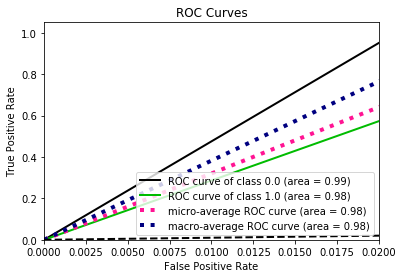

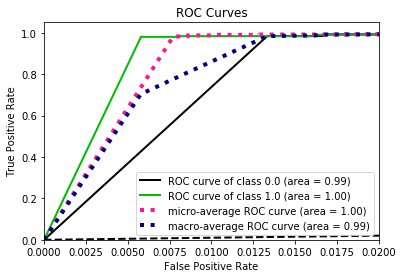

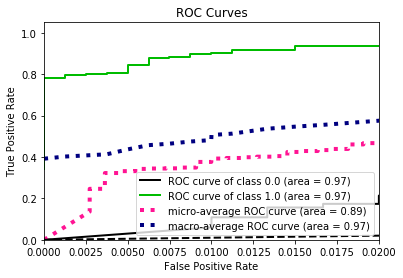

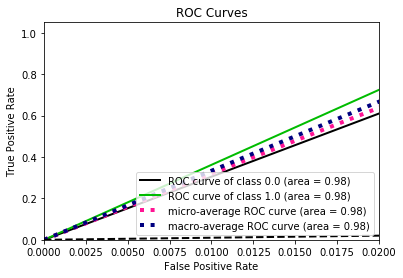

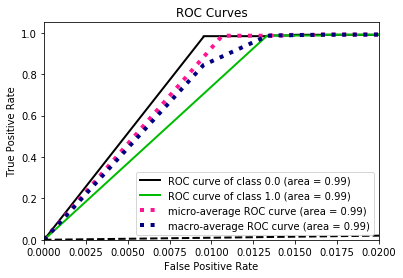

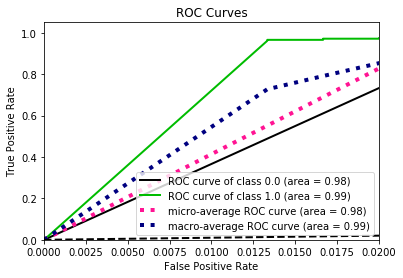

In [37]:
# gauss_nb
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"gauss_nb")
enron_measure_model

In [78]:
# svc
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"svc")
enron_measure_model

Processing Enron1...
Processing Enron2...
Processing Enron3...
Processing Enron4...
Processing Enron5...
Processing Enron6...


,Enron_dataset,spam,ham,train_spam,train_ham,test_spam,test_ham,tp,tn,fp,fn,acc,recall,specificity
0,enron1,1481,3653,1184,2922,297,731,145,680,51,152,80.174927,48.821549,93.023256
1,enron2,1496,4329,1196,3463,300,866,29,855,11,271,75.749786,9.666667,98.729792
2,enron3,1500,4002,1200,3201,300,801,139,770,31,161,82.486388,46.333333,96.129838
3,enron4,4458,1500,3566,1200,892,300,858,173,127,34,86.420788,96.188341,57.666667
4,enron5,3675,1500,2940,1200,735,300,683,43,257,52,70.077220,92.925170,14.333333
5,enron6,4499,1499,3599,1199,900,300,863,57,243,37,76.602831,95.888889,19.000000


In [75]:
# logistic
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"logistic")
enron_measure_model

Processing Enron1...
Processing Enron2...
Processing Enron3...
Processing Enron4...
Processing Enron5...
Processing Enron6...


,Enron_dataset,spam,ham,train_spam,train_ham,test_spam,test_ham,tp,tn,fp,fn,acc,recall,specificity
0,enron1,1481,3653,1184,2922,297,731,145,680,51,152,80.174927,48.821549,93.023256
1,enron2,1496,4329,1196,3463,300,866,29,855,11,271,75.749786,9.666667,98.729792
2,enron3,1500,4002,1200,3201,300,801,139,770,31,161,82.486388,46.333333,96.129838
3,enron4,4458,1500,3566,1200,892,300,858,173,127,34,86.420788,96.188341,57.666667
4,enron5,3675,1500,2940,1200,735,300,683,43,257,52,70.077220,92.925170,14.333333
5,enron6,4499,1499,3599,1199,900,300,863,57,243,37,76.602831,95.888889,19.000000


In [ ]:
# nn_classifier
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"nn_classifier")
enron_measure_model

In [ ]:
# decisionTree
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"decisionTree")
enron_measure_model 

In [23]:
# xgboost 
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"xgboost")
enron_measure_model

Processing Enron1...
[0]	eval-auc:0.968419	train-auc:0.996408
[1]	eval-auc:0.980305	train-auc:0.999725
[2]	eval-auc:0.993109	train-auc:0.999973
[3]	eval-auc:0.994394	train-auc:0.99999
[4]	eval-auc:0.994754	train-auc:1
[5]	eval-auc:0.995339	train-auc:1
[6]	eval-auc:0.995901	train-auc:1
[7]	eval-auc:0.996541	train-auc:1
[8]	eval-auc:0.996767	train-auc:1
[9]	eval-auc:0.996988	train-auc:1
[10]	eval-auc:0.997094	train-auc:1
[11]	eval-auc:0.997153	train-auc:1
[12]	eval-auc:0.997342	train-auc:1
[13]	eval-auc:0.997365	train-auc:1
[14]	eval-auc:0.997568	train-auc:1
[15]	eval-auc:0.997559	train-auc:1
[16]	eval-auc:0.99766	train-auc:1
[17]	eval-auc:0.99766	train-auc:1
[18]	eval-auc:0.997688	train-auc:1
[19]	eval-auc:0.997642	train-auc:1
[20]	eval-auc:0.997711	train-auc:1
[21]	eval-auc:0.99772	train-auc:1
[22]	eval-auc:0.99766	train-auc:1
[23]	eval-auc:0.997679	train-auc:1
[24]	eval-auc:0.997646	train-auc:1
[25]	eval-auc:0.997633	train-auc:1
[26]	eval-auc:0.997697	train-auc:1
[27]	eval-auc:0.99769

,Enron_dataset,spam,ham,train_spam,train_ham,test_spam,test_ham,tp,tn,fp,fn,acc,recall,specificity
0,enron1,1481,3653,1184,2922,297,731,289,723,8,8,98.347911,97.306397,98.905609
1,enron2,1496,4329,1196,3463,300,866,295,857,9,5,98.714653,98.333333,98.960739
2,enron3,1500,4002,1200,3201,300,801,287,795,6,13,98.185118,95.666667,99.250936
3,enron4,4458,1500,3566,1200,892,300,888,280,20,4,97.904443,99.551570,93.333333
4,enron5,3675,1500,2940,1200,735,300,731,287,13,4,98.262548,99.455782,95.666667
5,enron6,4499,1499,3599,1199,900,300,893,276,24,7,97.335554,99.222222,92.000000


In [ ]:
# lgb
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"lgb")
enron_measure_model

In [ ]:
# cat_gb
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"cat_gb")
enron_measure_model 

Processing Enron1...
Processing Enron2...
Processing Enron3...
Processing Enron4...
Processing Enron5...
Processing Enron6...


,Enron_dataset,spam,ham,train_spam,train_ham,test_spam,test_ham,tp,tn,fp,fn,acc,recall,specificity
0,enron1,1481,3653,1184,2922,297,731,290,723,8,7,98.445092,97.643098,98.905609
1,enron2,1496,4329,1196,3463,300,866,279,864,2,21,97.943445,93.000000,99.769053
2,enron3,1500,4002,1200,3201,300,801,277,800,1,23,97.731397,92.333333,99.875156
3,enron4,4458,1500,3566,1200,892,300,892,269,31,0,97.317687,100.000000,89.666667
4,enron5,3675,1500,2940,1200,735,300,733,290,10,2,98.745174,99.727891,96.666667
5,enron6,4499,1499,3599,1199,900,300,900,273,27,0,97.668609,100.000000,91.000000


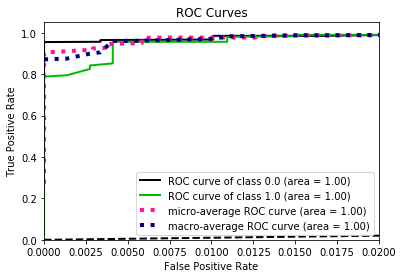

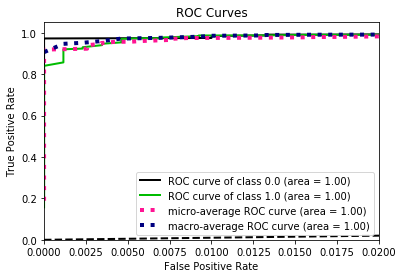

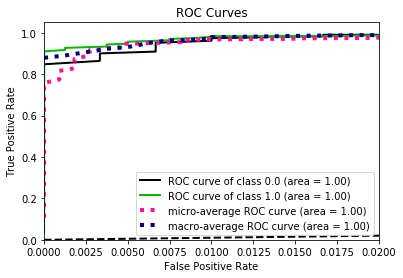

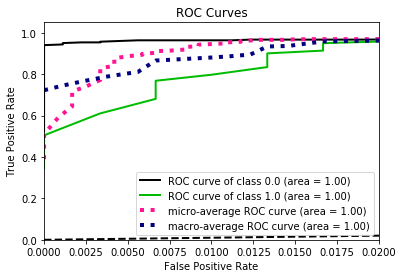

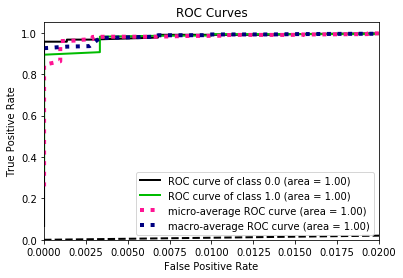

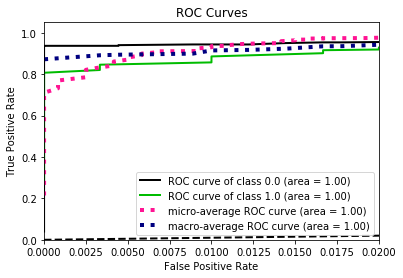

In [38]:
# random_forest
for i in range(1,7):
    print("Processing Enron"+str(i) +"...")
    enron_measure_model.loc[i-1] = exec_model(i,attributes_hot_encode,"random_forest")
enron_measure_model 

In [ ]:
print("Completed !")